# 学習
- パラメータチューニング

In [1]:
# パラメータ設定

In [2]:
TARGET_DATE = '20210101'

In [4]:
TARGET_DATE = str(TARGET_DATE)

In [5]:
# ライブラリ読み込み

In [6]:
import pandas as pd
import numpy as np
import argparse
import shap
import optuna
import pickle
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [7]:
# dataframe設定調整

In [8]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [9]:
# データ読み込み

In [10]:
train = pd.read_pickle(f'../../data/trial/feature_{TARGET_DATE}.pkl')

In [11]:
target = 'TARGET'

In [12]:
X = train.drop(columns=target)

In [13]:
y = train[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=0,
                                                   stratify=y)

In [15]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y_train)

In [16]:
categorical_features = [
# 'prefecture_code'
]

In [17]:
lgb_train = lgb.Dataset(X_train, y_train,
                       categorical_feature=categorical_features,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False)

In [18]:
def objective(trial):

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    evaluation_results = {}
    model = lgb.train(
        param,
        lgb_train,              
        num_boost_round=1000,
        valid_names=['train', 'valid'],    
        valid_sets=[lgb_train, lgb_eval],    
        evals_result=evaluation_results,     
        categorical_feature=categorical_features,
        early_stopping_rounds=50,               
        verbose_eval=10)   
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    
    # metrics AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
    score = metrics.auc(fpr, tpr)

    # metrics F1
#     score = f1_score(y_train, y_pred)

    # MLFlow
#     with mlflow.start_run() as run:
#         mlflow.log_params(param)
#         mlflow.log_metrics({'accuracy': accuracy})
#         mlflow.lightgbm.log_model(gbm, 'model', args.conda_env)
#     print('Model logged in run {}'.format(run.info.run_uuid))
    return score

In [19]:
# Optunaでパラメータチューニング
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2021-01-28 16:20:47,745] A new study created in memory with name: no-name-dee464ea-59a1-4ad1-b6d7-b0a60384733b


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.769115	valid's auc: 0.733526
[20]	train's auc: 0.79051	valid's auc: 0.738906
[30]	train's auc: 0.809686	valid's auc: 0.743084
[40]	train's auc: 0.828311	valid's auc: 0.744785
[50]	train's auc: 0.843216	valid's auc: 0.745398
[60]	train's auc: 0.857108	valid's auc: 0.745305
[70]	train's auc: 0.869127	valid's auc: 0.745104
[80]	train's auc: 0.879476	valid's auc: 0.744801
[90]	train's auc: 0.888758	valid's auc: 0.744301
[100]	train's auc: 0.897751	valid's auc: 0.743607
Early stopping, best iteration is:
[52]	train's auc: 0.846261	valid's auc: 0.745579


[I 2021-01-28 16:20:50,704] Trial 0 finished with value: 0.8462612826962773 and parameters: {'lambda_l1': 0.15926509580482884, 'lambda_l2': 0.3051193880598462, 'num_leaves': 138, 'feature_fraction': 0.9109638722062383, 'bagging_fraction': 0.9950299796800136, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 0 with value: 0.8462612826962773.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.744509	valid's auc: 0.731174
[20]	train's auc: 0.757284	valid's auc: 0.738743
[30]	train's auc: 0.767231	valid's auc: 0.743089
[40]	train's auc: 0.775026	valid's auc: 0.744688
[50]	train's auc: 0.781933	valid's auc: 0.746429
[60]	train's auc: 0.788528	valid's auc: 0.746922
[70]	train's auc: 0.79489	valid's auc: 0.747532
[80]	train's auc: 0.800416	valid's auc: 0.747664
[90]	train's auc: 0.805972	valid's auc: 0.747903
[100]	train's auc: 0.81131	valid's auc: 0.747542
[110]	train's auc: 0.815933	valid's auc: 0.747751
[120]	train's auc: 0.820508	valid's auc: 0.747848
[130]	train's auc: 0.825465	valid's auc: 0.747667
[140]	train's auc: 0.829523	valid's auc: 0.747094
Early stopping, best iteration is:
[91]	train's auc: 0.806403	valid's auc: 0.747921


[I 2021-01-28 16:20:53,934] Trial 1 finished with value: 0.8064033569989315 and parameters: {'lambda_l1': 1.4876276639907924, 'lambda_l2': 4.4541956458092274e-08, 'num_leaves': 45, 'feature_fraction': 0.9130506407206183, 'bagging_fraction': 0.49685470472158066, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 0 with value: 0.8462612826962773.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.779421	valid's auc: 0.733665
[20]	train's auc: 0.800914	valid's auc: 0.739796
[30]	train's auc: 0.818553	valid's auc: 0.739082
[40]	train's auc: 0.834735	valid's auc: 0.741141
[50]	train's auc: 0.85064	valid's auc: 0.742417
[60]	train's auc: 0.865708	valid's auc: 0.742286
[70]	train's auc: 0.879249	valid's auc: 0.741299
[80]	train's auc: 0.89152	valid's auc: 0.741252
[90]	train's auc: 0.902064	valid's auc: 0.739846
[100]	train's auc: 0.911483	valid's auc: 0.73974
Early stopping, best iteration is:
[52]	train's auc: 0.853896	valid's auc: 0.742817


[I 2021-01-28 16:20:56,573] Trial 2 finished with value: 0.8538960147202582 and parameters: {'lambda_l1': 0.0006882865985213919, 'lambda_l2': 1.4255195795393746e-06, 'num_leaves': 162, 'feature_fraction': 0.5670789673675076, 'bagging_fraction': 0.6271038814307107, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 2 with value: 0.8538960147202582.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.770755	valid's auc: 0.725738
[20]	train's auc: 0.791152	valid's auc: 0.739931
[30]	train's auc: 0.804664	valid's auc: 0.742533
[40]	train's auc: 0.818416	valid's auc: 0.742576
[50]	train's auc: 0.83064	valid's auc: 0.743782
[60]	train's auc: 0.843274	valid's auc: 0.744555
[70]	train's auc: 0.855434	valid's auc: 0.744258
[80]	train's auc: 0.866685	valid's auc: 0.743427
[90]	train's auc: 0.876592	valid's auc: 0.743798
[100]	train's auc: 0.885329	valid's auc: 0.743313
Early stopping, best iteration is:
[58]	train's auc: 0.840735	valid's auc: 0.745119


[I 2021-01-28 16:20:58,770] Trial 3 finished with value: 0.8407352382270263 and parameters: {'lambda_l1': 0.020536686448952655, 'lambda_l2': 0.07945851669252929, 'num_leaves': 133, 'feature_fraction': 0.4364932844127193, 'bagging_fraction': 0.8382729791427604, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 2 with value: 0.8538960147202582.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.754555	valid's auc: 0.732793
[20]	train's auc: 0.766734	valid's auc: 0.741478
[30]	train's auc: 0.774613	valid's auc: 0.743415
[40]	train's auc: 0.782798	valid's auc: 0.74443
[50]	train's auc: 0.790968	valid's auc: 0.745799
[60]	train's auc: 0.798908	valid's auc: 0.746974
[70]	train's auc: 0.806807	valid's auc: 0.747543
[80]	train's auc: 0.814088	valid's auc: 0.747741
[90]	train's auc: 0.821282	valid's auc: 0.74819
[100]	train's auc: 0.826965	valid's auc: 0.748306
[110]	train's auc: 0.832932	valid's auc: 0.748582
[120]	train's auc: 0.838937	valid's auc: 0.748536
[130]	train's auc: 0.843319	valid's auc: 0.748618
[140]	train's auc: 0.848177	valid's auc: 0.748586
[150]	train's auc: 0.852625	valid's auc: 0.74802
[160]	train's auc: 0.85709	valid's auc: 0.748257
Early stopping, best iteration is:
[112]	train's auc: 0.834012	valid's auc: 0.748751


[I 2021-01-28 16:21:03,006] Trial 4 finished with value: 0.8340117560364592 and parameters: {'lambda_l1': 0.07772368062238, 'lambda_l2': 3.0204075165882268e-05, 'num_leaves': 56, 'feature_fraction': 0.5108065126828272, 'bagging_fraction': 0.9357049276167825, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 2 with value: 0.8538960147202582.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.76633	valid's auc: 0.727852
[20]	train's auc: 0.789618	valid's auc: 0.73247
[30]	train's auc: 0.811566	valid's auc: 0.73455
[40]	train's auc: 0.831996	valid's auc: 0.735009
[50]	train's auc: 0.848069	valid's auc: 0.736054
[60]	train's auc: 0.862677	valid's auc: 0.733893
[70]	train's auc: 0.875807	valid's auc: 0.732513
[80]	train's auc: 0.88793	valid's auc: 0.731424
[90]	train's auc: 0.899512	valid's auc: 0.730065
Early stopping, best iteration is:
[48]	train's auc: 0.844633	valid's auc: 0.73654


[I 2021-01-28 16:21:05,558] Trial 5 finished with value: 0.8446328935658733 and parameters: {'lambda_l1': 1.0492811151204954e-07, 'lambda_l2': 0.024562203114819877, 'num_leaves': 144, 'feature_fraction': 0.8385678727141948, 'bagging_fraction': 0.43804701636223276, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 2 with value: 0.8538960147202582.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.776458	valid's auc: 0.731429
[20]	train's auc: 0.798977	valid's auc: 0.74118
[30]	train's auc: 0.814218	valid's auc: 0.743483
[40]	train's auc: 0.830473	valid's auc: 0.744103
[50]	train's auc: 0.844728	valid's auc: 0.744193
[60]	train's auc: 0.858926	valid's auc: 0.743697
[70]	train's auc: 0.872216	valid's auc: 0.742529
[80]	train's auc: 0.883226	valid's auc: 0.741778
[90]	train's auc: 0.893255	valid's auc: 0.740406
Early stopping, best iteration is:
[43]	train's auc: 0.834687	valid's auc: 0.74477


[I 2021-01-28 16:21:07,899] Trial 6 finished with value: 0.8346867152114532 and parameters: {'lambda_l1': 3.066148147212901e-05, 'lambda_l2': 0.00016075653787870858, 'num_leaves': 157, 'feature_fraction': 0.5224746668029798, 'bagging_fraction': 0.6847353245276331, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 2 with value: 0.8538960147202582.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.743558	valid's auc: 0.733369
[20]	train's auc: 0.750358	valid's auc: 0.738393
[30]	train's auc: 0.754133	valid's auc: 0.739753
[40]	train's auc: 0.758331	valid's auc: 0.74245
[50]	train's auc: 0.762237	valid's auc: 0.744402
[60]	train's auc: 0.765741	valid's auc: 0.745451
[70]	train's auc: 0.769013	valid's auc: 0.746732
[80]	train's auc: 0.771557	valid's auc: 0.746485
[90]	train's auc: 0.774287	valid's auc: 0.747
[100]	train's auc: 0.776786	valid's auc: 0.747432
[110]	train's auc: 0.779492	valid's auc: 0.74746
[120]	train's auc: 0.781721	valid's auc: 0.747316
[130]	train's auc: 0.784253	valid's auc: 0.747349
[140]	train's auc: 0.786545	valid's auc: 0.747406
[150]	train's auc: 0.78907	valid's auc: 0.747415
[160]	train's auc: 0.791543	valid's auc: 0.747702
[170]	train's auc: 0.793589	valid's auc: 0.747627
[180]	train's auc: 0.796061	valid's auc: 0.747727
[190]	train's auc: 0.798255	valid's auc: 0.747885
[200

[I 2021-01-28 16:21:11,631] Trial 7 finished with value: 0.7977941873793 and parameters: {'lambda_l1': 0.6032561675552176, 'lambda_l2': 0.010710584769922676, 'num_leaves': 20, 'feature_fraction': 0.5784222964950472, 'bagging_fraction': 0.5891075325608808, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 2 with value: 0.8538960147202582.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.771246	valid's auc: 0.733724
[20]	train's auc: 0.790687	valid's auc: 0.738987
[30]	train's auc: 0.806179	valid's auc: 0.739261
[40]	train's auc: 0.820618	valid's auc: 0.74022
[50]	train's auc: 0.833738	valid's auc: 0.740255
[60]	train's auc: 0.847745	valid's auc: 0.740008
[70]	train's auc: 0.860168	valid's auc: 0.739844
[80]	train's auc: 0.869171	valid's auc: 0.739462
[90]	train's auc: 0.879223	valid's auc: 0.739121
[100]	train's auc: 0.887929	valid's auc: 0.739512
Early stopping, best iteration is:
[53]	train's auc: 0.837397	valid's auc: 0.740821


[I 2021-01-28 16:21:13,857] Trial 8 finished with value: 0.8373971348109253 and parameters: {'lambda_l1': 7.735486377898367e-08, 'lambda_l2': 6.738904040039424e-05, 'num_leaves': 129, 'feature_fraction': 0.4693932932439852, 'bagging_fraction': 0.770216808527307, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 2 with value: 0.8538960147202582.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.78166	valid's auc: 0.722806
[20]	train's auc: 0.806128	valid's auc: 0.734642
[30]	train's auc: 0.825286	valid's auc: 0.735228
[40]	train's auc: 0.841759	valid's auc: 0.735499
[50]	train's auc: 0.856998	valid's auc: 0.734683
[60]	train's auc: 0.871708	valid's auc: 0.731859
[70]	train's auc: 0.885039	valid's auc: 0.730139
[80]	train's auc: 0.897337	valid's auc: 0.728178
Early stopping, best iteration is:
[39]	train's auc: 0.839845	valid's auc: 0.735812


[I 2021-01-28 16:21:16,347] Trial 9 finished with value: 0.8398447528554931 and parameters: {'lambda_l1': 3.1455289749316575e-08, 'lambda_l2': 9.488387125302119e-06, 'num_leaves': 233, 'feature_fraction': 0.4685048642700117, 'bagging_fraction': 0.42521474001912285, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 2 with value: 0.8538960147202582.


Number of finished trials: 10
Best trial:
  Value: 0.8538960147202582
  Params: 
    lambda_l1: 0.0006882865985213919
    lambda_l2: 1.4255195795393746e-06
    num_leaves: 162
    feature_fraction: 0.5670789673675076
    bagging_fraction: 0.6271038814307107
    bagging_freq: 1
    min_child_samples: 34


In [20]:
# 二値分類
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',     
         }

In [21]:
params = dict(params, **study.best_params)

In [22]:
evaluation_results = {}
model = lgb.train(
    param,
    lgb_train,              
    num_boost_round=1000,
    valid_names=['train', 'valid'],    
    valid_sets=[lgb_train, lgb_eval],    
    evals_result=evaluation_results,     
    categorical_feature=categorical_features,
    early_stopping_rounds=50,               
    verbose_eval=10)   

# best_iterationを保存
optimum_boost_rounds = model.best_iteration

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15390, number of negative: 175016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3201
[LightGBM] [Info] Number of data points in the train set: 190406, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080827 -> initscore=-2.431159
[LightGBM] [Info] Start training from score -2.431159
Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.779421	valid's auc: 0.733665
[20]	train's auc: 0.800914	valid's auc: 0.739796
[30]	train's auc: 0.818553	valid's auc: 0.739082
[40]	train's auc: 0.834735	valid's auc: 0.741141
[50]	train's auc: 0.85064	valid's auc: 0.742417
[60]	train's auc: 0.865708	valid's auc: 0.742286
[70

0.8538960147202582


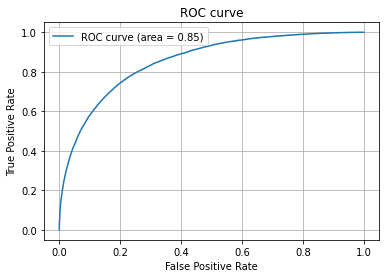

In [23]:
# # 訓練データを予測
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.7500312576697059


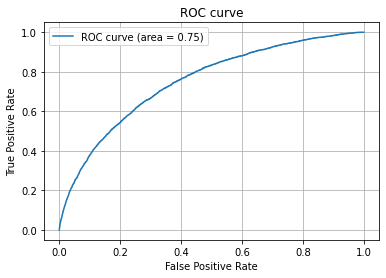

In [24]:
# # テストデータを予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [25]:
pickle.dump(model, open(f'../../data/trial/model_{TARGET_DATE}.pkl', 'wb'))